In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy.stats import ttest_ind
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp
from gseapy import barplot, dotplot
from gseapy.plot import gseaplot
from sanbomics.plots import volcano
from sanbomics.tools import id_map
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from skopt import BayesSearchCV
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
import scanpy as sc

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Survival analysis

In [258]:
sur= pd.read_csv(r" Kaplan Meier.txt", sep='\t') # Replace with path for Kaplan Meier.txt, keep r"" 
tmakmf=sur[sur['Group']=='TMA']
twakmf=sur[sur['Group']=='TWA']
malkmf=sur[sur['gender']=='male']
femkmf=sur[sur['gender']=='female']
kmftma=KaplanMeierFitter()
kmftwa=KaplanMeierFitter()
kmfmal=KaplanMeierFitter()
kmffem=KaplanMeierFitter()
kmf=KaplanMeierFitter()
kmftma.fit(tmakmf['days_to_death'],event_observed=(tmakmf['vital_status']=='Dead'), label='Tumors with nodal extensions')
kmftwa.fit(twakmf['days_to_death'],event_observed=(twakmf['vital_status']=='Dead'), label='Tumors without nodal extensions')
kmfmal.fit(malkmf['days_to_death'],event_observed=(malkmf['vital_status']=='Dead'), label='Males')
kmffem.fit(femkmf['days_to_death'],event_observed=(femkmf['vital_status']=='Dead'), label='Females')
kmf.fit(sur['days_to_death'],event_observed=(sur['vital_status']=='Dead'))

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 227 total observations, 74 right-censored observations>

In [234]:
kmf.median_survival_time_

732.0

In [235]:
kmftma.median_survival_time_

691.0

In [236]:
kmftwa.median_survival_time_

1213.0

In [237]:
kmfmal.median_survival_time_

723.0

In [238]:
kmffem.median_survival_time_

743.0

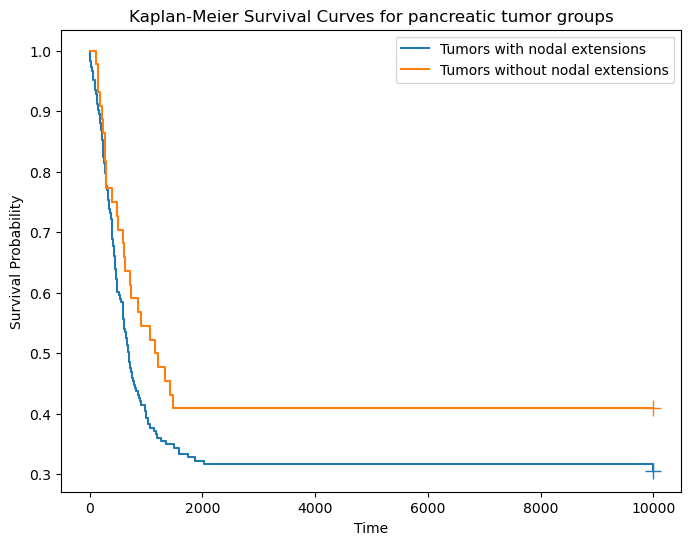

In [239]:
plt.figure(figsize=(8, 6))
kmftma.plot(ci_show= False, show_censors=True, censor_styles={"marker": "+"})
kmftwa.plot(ci_show= False, show_censors=True, censor_styles={"marker": "+"})
plt.title('Kaplan-Meier Survival Curves for pancreatic tumor groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

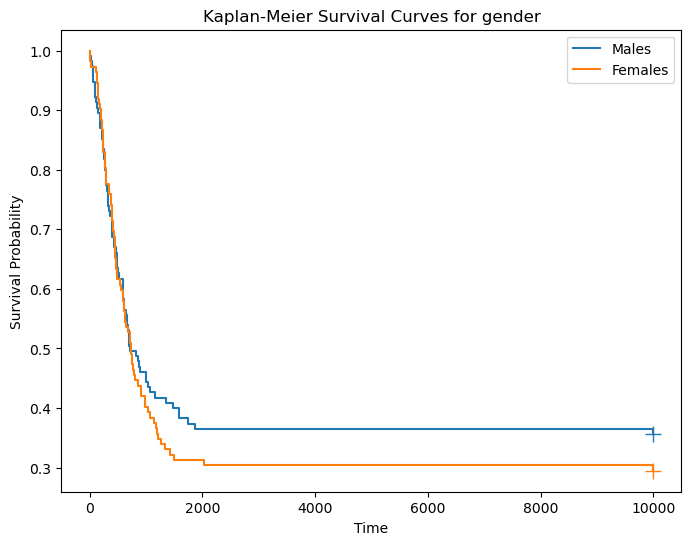

In [240]:
plt.figure(figsize=(8, 6))
kmfmal.plot(ci_show= False, show_censors=True, censor_styles={"marker": "+"})
kmffem.plot(ci_show= False, show_censors=True, censor_styles={"marker": "+"})

plt.title('Kaplan-Meier Survival Curves for gender')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

In [124]:
cphdf = sur.drop(['case_submitter_id','gender','age_at_index'],axis=1)

In [125]:
cphdf['Group']=cphdf['Group'].map({'TMA':1, 'TWA':0})
cphdf['vital_status']= cphdf['vital_status'].map({'Alive':0,'Dead':1})

In [126]:
cphdf['vital_status'].fillna(2, inplace=True)

In [127]:
cph = CoxPHFitter()
cph.fit(cphdf, duration_col='days_to_death', event_col='vital_status' )

<lifelines.CoxPHFitter: fitted with 227 total observations, 68 right-censored observations>

In [128]:
cph.hazard_ratios_

covariate
Group    1.370998
Name: exp(coef), dtype: float64

In [129]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 227 total observations, 68 right-censored observations>
             duration col = 'days_to_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 227
number of events observed = 159
   partial log-likelihood = -784.95
         time fit was run = 2023-12-22 16:27:30 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Group       0.32       1.37       0.21            -0.10             0.73                 0.91                 2.07

            cmp to    z    p   -log2(p)
covariate                              
Group         0.00 1.49 0.14       2.88
---
Concordance = 0.53
Partial AIC = 1571.89
log-likelihood ratio test = 2.38 on 1 df
-log2(p) of ll-ratio test = 3.03

In [201]:
from lifelines.statistics import logrank_test

# Assuming you have already fitted Kaplan-Meier curves for TMA and TWA (kmf_tma, kmf_twa)
results = logrank_test(tmakmf['days_to_death'], twakmf['days_to_death'], tmakmf['vital_status'] == 'Dead', twakmf['vital_status'] == 'Dead')

print(results.p_value)

0.15001424122561555


# Primary Characteristics of Study Population

In [243]:
chars= r" \Characteristics for Descriptive Statistics of Population.txt" # Replace with path for Characteristics for Descriptive Statistics of Population.txt
dfchars= pd.read_csv(chars, sep='\t')

In [246]:
dfchars['age_in_years']=dfchars['age_at_diagnosis_days']/365.25

In [247]:
dfchars.describe()

,days_to_death,age_at_diagnosis_days,age_in_years
count,208.000000,208.000000,208.000000
mean,3734.197115,23729.817308,64.968699
std,4485.176094,3854.696179,10.553583
min,1.000000,11659.000000,31.920602
25%,372.500000,21880.750000,59.906229
50%,748.500000,23881.500000,65.383984
75%,9999.000000,26699.000000,73.097878
max,9999.000000,31393.000000,85.949350


In [248]:
categorical_columns = ['vital_status', 'Group', 'gender', 'ajcc_pathologic_m', 'ajcc_pathologic_n', 'ajcc_pathologic_t', 'primary_diagnosis', 'site_of_resection_or_biopsy','ajcc_pathologic_stage']
categorical_summary = {col: dfchars[col].value_counts(normalize=True) for col in categorical_columns}

In [257]:
# Create an empty dictionary to store summaries
summary_dict = {}

# Iterate through each categorical column
for column in categorical_columns:
    # Calculate value counts
    value_counts = dfchars[column].value_counts()
    
    # Calculate percentages
    percentages = dfchars[column].value_counts(normalize=True) * 100
    
    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Count': value_counts,
        'Percentage': percentages
    })
    
    # Store the summary DataFrame in the dictionary
    summary_dict[column] = summary_df

# Print summaries for each categorical column
for column, summary_df in summary_dict.items():
    print(f"Summary for '{column}':\n{summary_df}\n")

Summary for 'vital_status':
         Count  Percentage
Dead       140   67.307692
Alive       62   29.807692
Unknown      6    2.884615

Summary for 'Group':
     Count  Percentage
TMA    168   80.769231
TWA     40   19.230769

Summary for 'gender':
        Count  Percentage
male      104        50.0
female    104        50.0

Summary for 'ajcc_pathologic_m':
         Count  Percentage
M0         191   91.826923
M1          14    6.730769
Unknown      2    0.961538
M1b          1    0.480769

Summary for 'ajcc_pathologic_n':
         Count  Percentage
N1         123   59.134615
N0          43   20.673077
N2          39   18.750000
Unknown      2    0.961538
N1b          1    0.480769

Summary for 'ajcc_pathologic_t':
         Count  Percentage
T3         138   66.346154
T2          57   27.403846
T4           4    1.923077
T1c          4    1.923077
Unknown      3    1.442308
T1           2    0.961538

Summary for 'primary_diagnosis':
                                                  

In [250]:
tmchars= dfchars[dfchars['Group']== 'TMA']

In [251]:
tmchars.describe()

,days_to_death,age_at_diagnosis_days,age_in_years
count,168.000000,168.000000,168.000000
mean,3533.809524,23405.196429,64.079935
std,4415.540501,3976.482737,10.887016
min,1.000000,11659.000000,31.920602
25%,372.500000,21480.250000,58.809719
50%,708.000000,23606.000000,64.629706
75%,9999.000000,26293.500000,71.987680
max,9999.000000,31393.000000,85.949350


In [252]:
# Create an empty dictionary to store summaries
summary_tmdict = {}

# Iterate through each categorical column
for column in categorical_columns:
    # Calculate value counts
    value_counts = tmchars[column].value_counts()
    
    # Calculate percentages
    percentages = tmchars[column].value_counts(normalize=True) * 100
    
    # Create a summary DataFrame
    summary_tmdf = pd.DataFrame({
        'Count': value_counts,
        'Percentage': percentages
    })
    
    # Store the summary DataFrame in the dictionary
    summary_tmdict[column] = summary_tmdf

# Print summaries for each categorical column
for column, summary_tmdf in summary_tmdict.items():
    print(f"Summary for '{column}':\n{summary_tmdf}\n")

Summary for 'vital_status':
         Count  Percentage
Dead       117   69.642857
Alive       46   27.380952
Unknown      5    2.976190

Summary for 'Group':
     Count  Percentage
TMA    168       100.0

Summary for 'gender':
        Count  Percentage
female     88   52.380952
male       80   47.619048

Summary for 'ajcc_pathologic_m':
         Count  Percentage
M0         151   89.880952
M1          14    8.333333
Unknown      2    1.190476
M1b          1    0.595238

Summary for 'ajcc_pathologic_n':
         Count  Percentage
N1         123   73.214286
N2          39   23.214286
N0           3    1.785714
Unknown      2    1.190476
N1b          1    0.595238

Summary for 'ajcc_pathologic_t':
         Count  Percentage
T3         115   68.452381
T2          41   24.404762
T4           4    2.380952
T1c          4    2.380952
Unknown      3    1.785714
T1           1    0.595238

Summary for 'primary_diagnosis':
                                                    Count  Percentage
Inf

In [254]:
twchars= dfchars[dfchars['Group']=='TWA']

In [255]:
twchars.describe()

,days_to_death,age_at_diagnosis_days,age_in_years
count,40.000000,40.000000,40.000000
mean,4575.825000,25093.225000,68.701506
std,4731.510107,2965.680451,8.119591
min,117.000000,17628.000000,48.262834
25%,371.750000,23590.500000,64.587269
50%,1107.500000,25269.500000,69.184120
75%,9999.000000,27180.000000,74.414784
max,9999.000000,31222.000000,85.481177


In [256]:
# Create an empty dictionary to store summaries
summary_twdict = {}

# Iterate through each categorical column
for column in categorical_columns:
    # Calculate value counts
    value_counts = twchars[column].value_counts()
    
    # Calculate percentages
    percentages = twchars[column].value_counts(normalize=True) * 100
    
    # Create a summary DataFrame
    summary_twdf = pd.DataFrame({
        'Count': value_counts,
        'Percentage': percentages
    })
    
    # Store the summary DataFrame in the dictionary
    summary_twdict[column] = summary_twdf

# Print summaries for each categorical column
for column, summary_twdf in summary_twdict.items():
    print(f"Summary for '{column}':\n{summary_twdf}\n")

Summary for 'vital_status':
         Count  Percentage
Dead        23        57.5
Alive       16        40.0
Unknown      1         2.5

Summary for 'Group':
     Count  Percentage
TWA     40       100.0

Summary for 'gender':
        Count  Percentage
male       24        60.0
female     16        40.0

Summary for 'ajcc_pathologic_m':
    Count  Percentage
M0     40       100.0

Summary for 'ajcc_pathologic_n':
    Count  Percentage
N0     40       100.0

Summary for 'ajcc_pathologic_t':
    Count  Percentage
T3     23        57.5
T2     16        40.0
T1      1         2.5

Summary for 'primary_diagnosis':
                                  Count  Percentage
Infiltrating duct carcinoma, NOS     36        90.0
Adenocarcinoma, NOS                   4        10.0

Summary for 'site_of_resection_or_biopsy':
                                Count  Percentage
Head of pancreas                   24        60.0
Pancreas, NOS                       7        17.5
Body of pancreas                 

# Script for parsing through TCGA data
Here we take advantage of the "clinical" data attached to TCGA files, which has TNM staging as well as file names. This means we can systematically parse through TCGA data without having to manually curate them which reduces the amount of time needed to navigate through all patients to separate them into controls and interest group.

In [5]:
# Read the list from list.txt
list_file_path = r" TWA train\List.txt" # Replace with path to TWA train\list.txt

# Read list.txt into a DataFrame
list_df = pd.read_csv(list_file_path, sep='\t')

target_folders = list(list_df['id'])

# Directory path
base_directory = r" \TWA train\Included" # Replace with path to \TWA train\Included

# Create a list to store the DataFrames
dataframes = []
counter = 1

for folder_name in target_folders:
    folder_path = os.path.join(base_directory, folder_name)
    
    # Check if the folder exists
    if os.path.isdir(folder_path):
        # Iterate over the files in the folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path) and file_name.endswith(".tsv"):
                
                # Create a DataFrame from the file
                df = pd.read_csv(file_path, sep='\t', comment='#', na_values=['N_unmapped', 'N_multimapping', 'N_noFeature', 'N_ambiguous'])
                df = df.dropna(subset=['gene_id'])
                # Give the DataFrame a name based on the file name
                dataframe_name = f"tw{counter}"
                counter += 1
                
                # Add the DataFrame to the list
                dataframes.append((dataframe_name, df))

# Create a dictionary to store the DataFrames with their respective names
twdf = dict(dataframes)

In [6]:
# Read the list from list.txt
list_file_path = r" \TMA train\tmatrainall\List.txt" # Replace with path to list.txt

# Read list.txt into a DataFrame
list_df = pd.read_csv(list_file_path, sep='\t')

target_folders = list(list_df['id'])

# Directory path
base_directory = r" \TMA train\tmatrainall\gdc_download_20231222_142835.854848" # Replace with path to gdc_download_20231222_142835.854848

# Create a list to store the DataFrames
dataframes = []
counter = 1

for folder_name in target_folders:
    folder_path = os.path.join(base_directory, folder_name)
    
    # Check if the folder exists
    if os.path.isdir(folder_path):
        # Iterate over the files in the folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path) and file_name.endswith(".tsv"):
                
                # Create a DataFrame from the file
                df = pd.read_csv(file_path, sep='\t', comment='#', na_values=['N_unmapped', 'N_multimapping', 'N_noFeature', 'N_ambiguous'])
                df = df.dropna(subset=['gene_id'])
                # Give the DataFrame a name based on the file name
                dataframe_name = f"tm{counter}"
                counter += 1
                
                # Add the DataFrame to the list
                dataframes.append((dataframe_name, df))

# Create a dictionary to store the DataFrames with their respective names
tmdf = dict(dataframes)

# Prepping of the dataframes

In [7]:
ftwun = pd.DataFrame() # Prepping TWAs
for i in range(1,39):
    new_column = pd.DataFrame(zip(twdf[f'tw{i}']['unstranded']),columns = [f'tw{i}'])
    ftwun = pd.concat([ftwun, new_column], axis=1)
    
ftmun = pd.DataFrame() # Prepping TMAs (143 patients)
for i in range(1,143):
    new_column = pd.DataFrame(zip(tmdf[f'tm{i}']['unstranded']),columns = [f'tm{i}'])
    ftmun = pd.concat([ftmun, new_column], axis=1)
    
ftwcounts = pd.DataFrame(zip(tmdf['tm1']['gene_id']), columns = ['geneid']) # preparing the gene id column
ffcounts = pd.concat([ftwcounts,ftmun,ftwun], axis= 1) # preparing the counts table for DGE
ffcounts = ffcounts[ffcounts.sum(axis=1)>0] # remove the genes that have 0 counts across all samples
ffcounts = ffcounts.set_index('geneid')
ffcounts = ffcounts.T
m_list = ['d']* 143
w_list = ['c']* 38
condition_list = m_list + w_list
metadata = pd.DataFrame(zip(ffcounts.index, condition_list), columns = ['sample','condition'])
metadata = metadata.set_index('sample')

# Differential expression all

In [13]:
ffdds = DeseqDataSet(counts = ffcounts,
                  metadata = metadata,
                  design_factors = 'condition')

In [14]:
ffdds.deseq2()

Fitting size factors...
... done in 0.46 seconds.

Fitting dispersions...
... done in 18.05 seconds.

Fitting dispersion trend curve...
... done in 12.77 seconds.

Fitting MAP dispersions...
... done in 24.47 seconds.

Fitting LFCs...
... done in 16.54 seconds.

Refitting 2596 outliers.

Fitting dispersions...
... done in 1.40 seconds.

Fitting MAP dispersions...
... done in 1.43 seconds.

Fitting LFCs...
... done in 1.09 seconds.



In [15]:
ffstat_res = DeseqStats (ffdds, n_cpus = 10, contrast=('condition','d','c'))

In [16]:
ffstat_res.summary()

Running Wald tests...
... done in 8.29 seconds.



Log2 fold change & Wald test p-value: condition d vs c


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
geneid,,,,,,
ENSG00000000003.15,1464.876500,-0.039875,0.109923,-0.362750,0.716791,0.876789
ENSG00000000005.6,12.053701,-0.282896,0.339879,-0.832345,0.405214,0.739055
ENSG00000000419.13,1264.528422,-0.101801,0.071514,-1.423516,0.154587,0.635524
ENSG00000000457.14,975.163783,0.127583,0.098260,1.298429,0.194140,0.656701
ENSG00000000460.17,355.198600,0.054917,0.120914,0.454184,0.649697,0.844856
...,...,...,...,...,...,...
ENSG00000288667.1,20.405121,0.408095,0.469850,0.868564,0.385086,0.731405
ENSG00000288669.1,0.237891,-0.949819,0.882822,-1.075890,0.281976,NaN
ENSG00000288670.1,199.945142,-0.029817,0.084496,-0.352876,0.724181,0.880399


In [17]:
ffres = ffstat_res.results_df

In [19]:
ffres = pd.merge(ffres,tmdf['tm1'][['gene_id','gene_name']], left_on= ffres.index, right_on='gene_id', how= 'left')

In [32]:
ffres

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id,gene_name
0,1464.876500,-0.039875,0.109923,-0.362750,0.716791,0.876789,ENSG00000000003.15,TSPAN6
1,12.053701,-0.282896,0.339879,-0.832345,0.405214,0.739055,ENSG00000000005.6,TNMD
2,1264.528422,-0.101801,0.071514,-1.423516,0.154587,0.635524,ENSG00000000419.13,DPM1
3,975.163783,0.127583,0.098260,1.298429,0.194140,0.656701,ENSG00000000457.14,SCYL3
4,355.198600,0.054917,0.120914,0.454184,0.649697,0.844856,ENSG00000000460.17,C1orf112
...,...,...,...,...,...,...,...,...
57092,20.405121,0.408095,0.469850,0.868564,0.385086,0.731405,ENSG00000288667.1,AC078856.1
57093,0.237891,-0.949819,0.882822,-1.075890,0.281976,NaN,ENSG00000288669.1,AC008763.4
57094,199.945142,-0.029817,0.084496,-0.352876,0.724181,0.880399,ENSG00000288670.1,AL592295.6
57095,6.960504,0.051827,0.180505,0.287122,0.774019,0.903623,ENSG00000288674.1,AL391628.1


In [205]:
fdegs = ffres[(abs(ffres.log2FoldChange) > 0.5)&(ffres.padj<0.05)]

In [206]:
fdegs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id,gene_name
195,97.862031,1.235632,0.320159,3.859431,1.136516e-04,0.037748,NaN,NaN
411,686.920407,1.236756,0.305619,4.046726,5.193893e-05,0.023390,NaN,NaN
531,18.115533,1.712277,0.336541,5.087871,3.621055e-07,0.000924,NaN,NaN
863,3635.301336,-0.734857,0.195394,-3.760908,1.692978e-04,0.044481,NaN,NaN
1237,4.498691,-1.359997,0.351445,-3.869730,1.089561e-04,0.037573,NaN,NaN
...,...,...,...,...,...,...,...,...
53367,8.768907,4.952310,0.912801,5.425402,5.782437e-08,0.000316,ENSG00000280441.3,FP236383.3
53494,85.721958,2.168678,0.538928,4.024058,5.720371e-05,0.025461,ENSG00000281383.1,FP671120.7
54591,1.892826,1.093308,0.291147,3.755180,1.732170e-04,0.044481,ENSG00000285567.2,AC074051.3
56095,14.247427,1.982636,0.502009,3.949404,7.834597e-05,0.030292,ENSG00000287198.1,AC092979.2


# GSEA all

In [13]:
alranking = ffres[['gene_name','stat']].dropna().sort_values('stat',ascending= False)

In [14]:
alranking

,gene_name,stat
37191,LINC01234,5.716183
1874,SI,5.467536
17067,POTEF,5.452550
53367,FP236383.3,5.425402
15155,LIPF,5.388645
...,...,...
21631,CGB8,-5.241861
13457,SAA1,-5.319642
5516,LYPD3,-5.429008
10840,LRRTM1,-6.198468


In [15]:
pre_res1 = gp.prerank (rnk= alranking, gene_sets = r" Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c2.cp.kegg.v2023.1.Hs.symbols.gmt", min_size = 150) #Replace with path to Gene Sets for KEGG
out1 = []

for term in list(pre_res1.results):
    out1.append([term,
               pre_res1.results[term]['fdr'],
               pre_res1.results[term]['es'],
               pre_res1.results[term]['nes'],
               pre_res1.results[term]['pval'],
                pre_res1.results[term]['matched_genes']])

out_df1 = pd.DataFrame(out1, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df1

2024-07-08 15:45:46,912 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 15:45:46,948 [WARNING] Duplicated values found in preranked stats: 4.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,KEGG_ENDOCYTOSIS,0.000000,-0.420897,-2.019230,0.000000,HSPA6;HSPA1B;ERBB3;CBLB;HSPA1A;USP8;WWP1;RET;M...
1,KEGG_CHEMOKINE_SIGNALING_PATHWAY,0.000000,-0.369573,-1.786135,0.000000,CCL25;XCL1;PLCB4;SOS1;GNG13;PPBP;GRK7;CCL14;PI...
2,KEGG_MAPK_SIGNALING_PATHWAY,0.000000,-0.301220,-1.531637,0.000000,CHP2;HSPA6;MAP3K13;HSPA1B;SOS1;MAPT;HSPA1A;NFA...
3,KEGG_ALZHEIMERS_DISEASE,0.000000,-0.473796,-2.288519,0.000000,CHP2;PLCB4;MAPT;COX6A2;EIF2AK3;COX8C;GRIN1;COX...
4,KEGG_REGULATION_OF_ACTIN_CYTOSKELETON,0.000000,-0.408600,-1.969757,0.000000,CHRM1;ITGA2B;SOS1;DIAPH2;GNA13;ACTN2;PIK3CA;MY...
5,KEGG_FOCAL_ADHESION,0.000000,-0.438219,-2.144101,0.000000,COL11A2;ITGA2B;CHAD;SOS1;PRKCA;PRKCG;ACTN2;PIK...
6,KEGG_HUNTINGTONS_DISEASE,0.000000,-0.475257,-2.328353,0.000000,SP1;PLCB4;COX6A2;POLR2J3;EP300;COX8C;DNAH3;GRI...
7,KEGG_WNT_SIGNALING_PATHWAY,0.000000,-0.306248,-1.478729,0.000000,CHP2;WIF1;PLCB4;NFATC2;PRKCA;PRKCG;FZD5;EP300;...
8,KEGG_PURINE_METABOLISM,0.000000,-0.385547,-1.877097,0.000000,PDE6A;GUCY2C;POLR2J3;PDE10A;PDE7B;PDE8A;POLR2J...
9,KEGG_PATHWAYS_IN_CANCER,0.000000,-0.361613,-1.890532,0.000000,ITGA2B;SOS1;CBLB;PIAS1;PRKCA;PRKCG;FZD5;MECOM;...


In [25]:
pre_res2 = gp.prerank (rnk= alranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c3.all.v2023.1.Hs.symbols.gmt", min_size =150) #Replace with path to Gene Sets for C3
out1 = []
out2 = []

for term in list(pre_res2.results):
    out2.append([term,
               pre_res2.results[term]['fdr'],
               pre_res2.results[term]['es'],
               pre_res2.results[term]['nes'],
               pre_res2.results[term]['pval'],
                pre_res2.results[term]['matched_genes']])

out_df2 = pd.DataFrame(out2, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df2

2024-07-08 15:56:29,720 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 15:56:29,771 [WARNING] Duplicated values found in preranked stats: 4.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,AP2_Q6,0.000000,-0.361935,-1.781865,0.000000,COL11A2;ARHGAP36;CLC;PABPC3;WAC;KCNH5;FZD5;FNB...
1,TFIIA_Q6,0.000000,-0.390252,-2.031401,0.000000,HOXA9;RNF38;NFIB;CLUL1;SLC39A5;INO80;EP300;BTB...
2,MIR4447,0.000000,-0.484619,-2.543575,0.000000,CNDP1;AVPR1A;MTCL1;AKAP13;PLEKHM3;C20orf203;CA...
3,MIR4725_3P,0.000000,-0.369015,-1.852981,0.000000,CSNK1G1;SP1;ZNF609;GPA33;HOXB9;FNBP1L;INO80D;E...
4,MIR149_3P,0.000000,-0.483022,-2.491935,0.000000,NOX1;COL11A2;ALPG;SV2C;SRRM4;RNF38;MAPT;CASP10...
...,...,...,...,...,...,...
1268,MIR9986,0.963220,0.203399,0.760870,0.930736,KRT20;FIGN;KLHL24;CTBP2;DIABLO;YOD1;LIMD1;GXYL...
1269,MIR1294,0.964147,0.202345,0.757955,0.938445,KRT20;FIGN;KLHL24;CTBP2;DIABLO;YOD1;LIMD1;GXYL...
1270,MIR509_5P,0.967624,0.199604,0.751597,0.935106,SHISA9;NHEJ1;FIGN;INO80D;GOLGA1;CDC14A;DOCK3;T...
1271,SRY_02,0.968761,0.193054,0.748229,0.968685,EPHA7;MSI2;PPM1D;RBFOX1;NFIB;PIAS1;NR4A3;ZNF66...


In [16]:
pre_res3 = gp.prerank (rnk= alranking, gene_sets = r" \Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c3.mir.v2023.1.Hs.symbols.gmt", min_size = 150) #Replace with path 
out1 = []
out3 = []

for term in list(pre_res3.results):
    out3.append([term,
               pre_res3.results[term]['fdr'],
               pre_res3.results[term]['es'],
               pre_res3.results[term]['nes'],
               pre_res3.results[term]['pval'],
                pre_res3.results[term]['matched_genes']])

out_df3 = pd.DataFrame(out3, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df3

2024-07-08 15:46:04,010 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 15:46:04,046 [WARNING] Duplicated values found in preranked stats: 4.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,MIR6887_3P,0.000000,-0.377183,-1.855085,0.000000,MS4A15;CNPY2;PPP4R3A;SRCIN1;TET3;MYO10;RND1;PC...
1,MIR6883_5P,0.000000,-0.469409,-2.466501,0.000000,NOX1;COL11A2;ALPG;SV2C;SRRM4;RNF38;MAPT;CASP10...
2,MIR4725_3P,0.000000,-0.369015,-1.852981,0.000000,CSNK1G1;SP1;ZNF609;GPA33;HOXB9;FNBP1L;INO80D;E...
3,MIR4271,0.000000,-0.404024,-1.953154,0.000000,CSNK1G1;FNBP1L;INO80D;EP300;TET3;BCAS3;KCNA1;Z...
4,CCTGCTG_MIR214,0.000000,-0.355218,-1.808752,0.000000,MOG;ATP8B5P;PLCB4;TUBA4B;ZNF609;MID1;MAPT;ARPP...
...,...,...,...,...,...,...
743,MIR509_3_5P,0.958080,0.204374,0.767147,0.927273,SHISA9;NHEJ1;FIGN;INO80D;GOLGA1;CDC14A;DOCK3;T...
744,MIR9986,0.961749,0.203399,0.760870,0.930736,KRT20;FIGN;KLHL24;CTBP2;DIABLO;YOD1;LIMD1;GXYL...
745,MIR1294,0.962484,0.202345,0.757955,0.938445,KRT20;FIGN;KLHL24;CTBP2;DIABLO;YOD1;LIMD1;GXYL...
746,MIR509_5P,0.965811,0.199604,0.751597,0.935106,SHISA9;NHEJ1;FIGN;INO80D;GOLGA1;CDC14A;DOCK3;T...


In [17]:
pre_res4 = gp.prerank (rnk= alranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c3.tft.v2023.1.Hs.symbols.gmt", min_size = 150) #Replace with path 
out4 = []

for term in list(pre_res4.results):
    out4.append([term,
               pre_res4.results[term]['fdr'],
               pre_res4.results[term]['es'],
               pre_res4.results[term]['nes'],
               pre_res4.results[term]['pval'],
                pre_res4.results[term]['matched_genes']])

out_df4 = pd.DataFrame(out4, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df4

2024-07-08 15:47:32,042 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 15:47:32,087 [WARNING] Duplicated values found in preranked stats: 4.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,SREBP1_Q6,0.0,-0.371961,-1.845001,0.000000,IGF2BP1;SRRM4;KMT2E;HOXA11;GUCA2B;SLC4A1;RBFOX...
1,NFE2_01,0.0,-0.434684,-2.197457,0.000000,MYB;DOC2A;CLC;HOXA11;SV2B;TUBA4B;CA7;VEZF1;CAP...
2,MAZ_Q6,0.0,-0.401309,-1.939083,0.000000,UPF2;TSSK3;WAC;HCRTR1;FNBP1L;UBE4B;CELF1;PTPN5...
3,COUP_DR1_Q6,0.0,-0.397253,-1.997677,0.000000,SLC26A3;MTTP;PAX7;FABP1;ADAMTS19;FXYD1;RBBP6;S...
4,ATF_B,0.0,-0.425124,-2.107892,0.000000,MAP3K13;VIP;SRRM4;CLDN6;NR2E1;FOXD3;GPM6B;DEPD...
...,...,...,...,...,...,...
520,NKX22_01,1.0,0.251163,0.956938,0.588608,PHOX2B;NKX2-8;CHRM1;MIR137HG;FNBP1L;GOLGA1;NED...
521,OCT1_07,1.0,0.314141,1.186549,0.132686,PHOX2B;CSNK1G1;ATOH1;MID1;HEPACAM;BTBD3;BRD8;M...
522,STAT6_01,1.0,0.266302,1.044587,0.367662,PHOX2B;VIP;PTCHD1;GSTT4;GAREM1;TMC1;KDM6A;TNFR...
523,CART1_01,1.0,0.331624,1.290051,0.027055,SLC26A3;EPHA7;PHOX2B;LOXHD1;UNC13B;HOXA11;LGAL...


In [18]:
pre_res6 = gp.prerank (rnk= alranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c5.go.bp.v2023.1.Hs.symbols.gmt", min_size = 150) #Replace with path 
out6 = []

for term in list(pre_res6.results):
    out6.append([term,
               pre_res6.results[term]['fdr'],
               pre_res6.results[term]['es'],
               pre_res6.results[term]['nes'],
               pre_res6.results[term]['pval'],
                pre_res6.results[term]['matched_genes']])

out_df6 = pd.DataFrame(out6, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df6

2024-07-08 15:48:53,316 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 15:48:53,356 [WARNING] Duplicated values found in preranked stats: 4.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,GOBP_NEGATIVE_REGULATION_OF_LYMPHOCYTE_ACTIVATION,0.0,-0.417643,-2.021690,0.000000,XCL1;CBLB;IL20RB;PAWR;VTCN1;PLA2G2F;CTSG;IL4;T...
1,GOBP_REGULATION_OF_LYMPHOCYTE_ACTIVATION,0.0,-0.368318,-1.965632,0.000000,PCK1;XCL1;CLC;VCAM1;SOS1;CGAS;CBLB;IL20RB;HSPH...
2,GOBP_KERATINOCYTE_DIFFERENTIATION,0.0,-0.440109,-2.137523,0.000000,KRT73;CDSN;FOXN1;EXPH5;LIPK;KRT72;UGCG;REG3A;L...
3,GOBP_INTRACELLULAR_GLUCOSE_HOMEOSTASIS,0.0,-0.367917,-1.728079,0.000000,PCK1;OPRK1;UNC13B;TRA2B;CMA1;SIN3A;GHRHR;PIK3C...
4,GOBP_NEGATIVE_REGULATION_OF_IMMUNE_RESPONSE,0.0,-0.432734,-2.147073,0.000000,XCL1;IL20RB;NPY5R;ENPP3;GPR17;ACOD1;IL33;IL4;U...
...,...,...,...,...,...,...
659,GOBP_SINGLE_FERTILIZATION,1.0,0.252192,0.944893,0.621912,HOXA9;UNC13B;HOXA11;ZAN;RNASE10;RIMS1;PRND;IZU...
660,GOBP_RESPONSE_TO_TEMPERATURE_STIMULUS,1.0,0.278131,1.053961,0.355932,HSPA6;HSP90AA2P;HSP90AA4P;PIRT;CHORDC1;DNAJB4;...
661,GOBP_FERTILIZATION,1.0,0.226971,0.868513,0.790698,SYCP2;HOXA9;UNC13B;HOXA11;ZAN;RNASE10;RIMS1;KL...
662,GOBP_MONOCARBOXYLIC_ACID_TRANSPORT,1.0,0.226198,0.864442,0.794055,SLC10A2;SPX;FABP7;FABP2;FABP1;FABP9;CYP4F2;SLC...


In [19]:
pre_res7 = gp.prerank (rnk= alranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c5.go.cc.v2023.1.Hs.symbols.gmt", min_size = 150) #Replace with path 
out7= []

for term in list(pre_res7.results):
    out7.append([term,
               pre_res7.results[term]['fdr'],
               pre_res7.results[term]['es'],
               pre_res7.results[term]['nes'],
               pre_res7.results[term]['pval'],
                pre_res7.results[term]['matched_genes']])

out_df7 = pd.DataFrame(out7, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df7

2024-07-08 15:50:48,312 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 15:50:48,359 [WARNING] Duplicated values found in preranked stats: 4.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,GOCC_MICROTUBULE,0.0,-0.334735,-1.818264,0.000000,TUBGCP4;TTLL9;TUBA4B;HSPH1;MID1;MAPT;WHAMM;FIG...
1,GOCC_ENDOPLASMIC_RETICULUM_LUMEN,0.0,-0.515451,-2.612458,0.000000,MTTP;COL11A2;COL28A1;APOA4;APOA5;ARSH;RDH5;FGA...
2,GOCC_POSTSYNAPTIC_SPECIALIZATION,0.0,-0.310812,-1.634858,0.000000,EPHA7;ARC;CHRM1;SHISA9;CRIPT;SOS1;GABRA3;GAP43...
3,GOCC_SPINDLE,0.0,-0.398924,-2.167102,0.000000,TUBGCP4;MID1;MBIP;TFDP2;MTCL1;INO80;CCDC117;CD...
4,GOCC_LATE_ENDOSOME,0.0,-0.424751,-2.189755,0.000000,SFTPB;NAPSA;APOA5;SLC17A8;ASTN2;OSBPL1A;SFTPC;...
...,...,...,...,...,...,...
93,GOCC_NON_MOTILE_CILIUM,1.0,0.235918,0.896525,0.703545,PDE6A;CNGA1;SHANK2;PKD1L1;STRCP1;STRC;CDC14A;G...
94,GOCC_CLUSTER_OF_ACTIN_BASED_CELL_PROJECTIONS,1.0,0.271817,1.021295,0.457573,SI;SLC26A3;TMPRSS15;MTTP;ITLN1;SLC28A1;SLC7A9;...
95,GOCC_CENTRIOLE,1.0,0.246600,0.926171,0.663399,HSPA6;HSPA1B;HSPA1A;OFD1;IFT81;KIF24;CEP295NL;...
96,GOCC_PLASMA_MEMBRANE_SIGNALING_RECEPTOR_COMPLEX,1.0,0.198664,0.783502,0.943147,SHISA9;ITGA2B;ERBB3;TRBV20-1;TRBV29-1;IL23R;GR...


In [20]:
pre_res8 = gp.prerank (rnk= alranking, gene_sets = "GO_Molecular_Function_2023", min_size = 150) # Integrated path in GSEA (NO NEED TO REPLACE)
out8 = []

for term in list(pre_res8.results):
    out8.append([term,
               pre_res8.results[term]['fdr'],
               pre_res8.results[term]['es'],
               pre_res8.results[term]['nes'],
               pre_res8.results[term]['pval'],
                pre_res8.results[term]['matched_genes']])

out_df8 = pd.DataFrame(out8, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df8

2024-07-08 15:51:12,177 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 15:51:12,214 [WARNING] Duplicated values found in preranked stats: 4.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,Adenyl Ribonucleotide Binding (GO:0032559),0.000000,-0.286961,-1.478001,0.000000,ABCG5;HSP90AA2P;HSP90AA4P;WNK4;ABCG8;ATP1A2;HS...
1,Calcium Ion Binding (GO:0005509),0.000000,-0.314597,-1.633838,0.000000,CHP2;ITLN1;CDH26;SCUBE1;CPNE6;LRP2;CLEC6A;TPT1...
2,Ribonucleoside Triphosphate Phosphatase Activi...,0.000000,-0.454099,-2.293649,0.000000,AGAP7P;RGS2;RGS5;RGS8;RAB6C;RND1;DDX3X;GNA13;N...
3,Ubiquitin-Like Protein Transferase Activity (G...,0.000000,-0.329593,-1.660340,0.000000,MYLIP;RBBP6;RNF186;ARIH1;BRAP;PIAS1;HUWE1;WWP1...
4,Actin Binding (GO:0003779),0.000000,-0.460919,-2.306318,0.000000,PIP;MAPT;PAWR;COBL;MICAL3;LMOD3;AVIL;HNRNPU;MY...
5,Zinc Ion Binding (GO:0008270),0.000000,-0.290867,-1.508001,0.000000,TAB3;CHORDC1;NPEPPSP1;ADH6;CBLB;ARIH1;ADH1C;AL...
6,GTPase Binding (GO:0051020),0.000000,-0.355978,-1.783698,0.000000,NOX1;UNC13B;FNBP1L;WHAMM;RIMS1;EXPH5;AKAP13;US...
7,Purine Ribonucleoside Triphosphate Binding (GO...,0.000000,-0.355152,-1.901530,0.000000,PCK1;ABCG5;HSP90AA2P;HSP90AA4P;WNK4;ABCG8;ATP1...
8,Receptor Ligand Activity (GO:0048018),0.000000,-0.384013,-2.008234,0.000000,EPHA7;VIP;CCL25;GUCA2A;TDGF1;NPPB;BMP3;HSPA1A;...
9,Tubulin Binding (GO:0015631),0.000000,-0.322959,-1.638856,0.000000,TUBGCP4;CRIPT;STMN4;TTLL9;MID1;MAPT;MTCL1;WHAM...


In [21]:
pre_res9 = gp.prerank (rnk= alranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c5.hpo.v2023.1.Hs.symbols.gmt", min_size = 150) #Replace with path 
out9= []

for term in list(pre_res9.results):
    out9.append([term,
               pre_res9.results[term]['fdr'],
               pre_res9.results[term]['es'],
               pre_res9.results[term]['nes'],
               pre_res9.results[term]['pval'],
                pre_res9.results[term]['matched_genes']])

out_df9 = pd.DataFrame(out9, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df9

2024-07-08 15:51:23,337 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 15:51:23,374 [WARNING] Duplicated values found in preranked stats: 4.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,HP_ABNORMALITY_OF_THE_LARYNX,0.000000,-0.316205,-1.588333,0.000000,PPM1D;MID1;ATXN2;KANSL1;EP300;KAT6B;XPNPEP2;RS...
1,HP_DEVIATION_OF_THE_HAND_OR_OF_FINGERS_OF_THE_...,0.000000,-0.340512,-1.735286,0.000000,GATA5;DPYSL5;L1CAM;HOXA11;CRIPT;SPEN;SOS1;HOXA...
2,HP_ABNORMAL_CHORIORETINAL_MORPHOLOGY,0.000000,-0.358851,-1.710541,0.000000,RPE65;TUBGCP4;WAC;HHAT;ADAMTS18;CHD7;CRX;CASK;...
3,HP_ABNORMAL_EYELASH_MORPHOLOGY,0.000000,-0.411255,-2.107857,0.000000,SOX10;KDM6A;TUBGCP4;SPEN;TERC;EP300;CREBBP;SLC...
4,HP_FINGER_CLINODACTYLY,0.000000,-0.327783,-1.724444,0.000000,GATA5;L1CAM;HOXA11;SPEN;SOS1;HOXA13;H19;MECOM;...
...,...,...,...,...,...,...
585,HP_ABNORMALITY_OF_THE_TESTIS_SIZE,0.931030,0.223870,0.852847,0.799787,SOX10;PROK2;NR5A1;KLHL10;RSPO1;FLRT3;IL17RD;PM...
586,HP_THIN_UPPER_LIP_VERMILION,0.952212,0.227326,0.891792,0.767109,PPM1D;SPEN;WAC;MID1;HUWE1;BPTF;EP300;KAT6B;CRE...
587,HP_ABNORMALITY_OF_THE_PITUITARY_GLAND,1.000000,0.225423,0.894716,0.801829,NKX2-1;SOX10;PROK2;TDGF1;KCNJ18;APOA5;KANSL1;U...
588,HP_DECREASED_FERTILITY_IN_MALES,1.000000,0.310729,1.187461,0.138889,SYCP2;QRICH2;CFAP47;DNAH10;NR5A1;GCNA;STRC;CDC...


In [22]:
pre_res10 = gp.prerank (rnk= alranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c6.all.v2023.1.Hs.symbols.gmt", min_size = 150) #Replace with path 
out10 = []

for term in list(pre_res10.results):
    out10.append([term,
               pre_res10.results[term]['fdr'],
               pre_res10.results[term]['es'],
               pre_res10.results[term]['nes'],
               pre_res10.results[term]['pval'],
                pre_res10.results[term]['matched_genes']])

out_df10 = pd.DataFrame(out10, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df10

2024-07-08 15:53:17,335 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 15:53:17,376 [WARNING] Duplicated values found in preranked stats: 4.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,GCNP_SHH_UP_LATE.V1_DN,0.0,-0.514929,-2.470027,0.000000,RBBP6;NCOA7;TUBA4B;COX6A2;LGALS2;FOXD3;KPNA1;S...
1,AKT_UP.V1_DN,0.0,-0.424115,-2.023406,0.000000,SLC18A1;WIF1;FXYD1;CHAD;FMO2;SH3BGR;MSL2;PADI3...
2,ESC_J1_UP_LATE.V1_UP,0.0,-0.350989,-1.685751,0.000000,MTTP;H19;LGALS2;TDRD7;ANKRD1;CA4;ESX1;MYO6;RAB...
3,SRC_UP.V1_DN,0.0,-0.355448,-1.717148,0.000000,GFRA3;EIF3CL;CA7;KCNMB3;CAPN12;NPY5R;ZNF436;CO...
4,WNT_UP.V1_UP,0.0,-0.433513,-2.094521,0.000000,CPS1;TEN1;CLDN6;RETNLB;NEUROD2;ADGRB1;RSPO1;KC...
...,...,...,...,...,...,...
105,IL2_UP.V1_DN,1.0,0.218355,0.836359,0.836735,LIPF;FUT9;CLCA1;ZNF695;CUX2;RGS2;LINC00472;CAC...
106,PRC1_BMI_UP.V1_UP,1.0,0.228102,0.872110,0.779894,ACTL8;CYP2B6;PDE6A;CLCA1;CNGA1;AOC4P;RFPL2;CCN...
107,PTEN_DN.V1_UP,1.0,0.226084,0.863938,0.809024,DEFA5;INSL4;VCAM1;PRKAR2B;H1-6;RGS2;NGB;FNBP1L...
108,LTE2_UP.V1_DN,1.0,0.222384,0.852636,0.819810,PRKAR2B;ZNF140;MTCL1;MYO10;TDRD7;PLSCR1;ZNF84;...


In [23]:
pre_res12 = gp.prerank (rnk= alranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\h.all.v2023.1.Hs.symbols.gmt", min_size = 3) #Replace with path 
out12= []

for term in list(pre_res12.results):
    out12.append([term,
               pre_res12.results[term]['fdr'],
               pre_res12.results[term]['es'],
               pre_res12.results[term]['nes'],
               pre_res12.results[term]['pval'],
                pre_res12.results[term]['matched_genes']])

out_df12 = pd.DataFrame(out12, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df12

2024-07-08 15:53:45,477 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 15:53:45,512 [WARNING] Duplicated values found in preranked stats: 4.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,HALLMARK_APICAL_JUNCTION,0.000000,-0.535870,-2.571983,0.000000,WNK4;VCAM1;CLDN6;TNFRSF11B;CADM2;TJP1;CDSN;ACT...
1,HALLMARK_APICAL_SURFACE,0.000000,-0.536696,-2.087105,0.000000,SCUBE1;PKHD1;GSTM3;AKAP7;CD160;GATA3;ATP8B1;RH...
2,HALLMARK_MYC_TARGETS_V2,0.000000,-0.553402,-2.293844,0.000000,TMEM97;HSPD1;HSPE1;WDR43;NOP2;UTP20;RCL1;SORD;...
3,HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.000000,-0.626151,-3.146072,0.000000,PDHX;COX11;FXN;ETFDH;IDH3A;SDHA;MTRR;ABCB7;ALD...
4,HALLMARK_MTORC1_SIGNALING,0.000000,-0.532525,-2.561539,0.000000,TMEM97;IFRD1;TBK1;HSPD1;TXNRD1;HSPE1;IFI30;ASN...
5,HALLMARK_HYPOXIA,0.000000,-0.449141,-2.199355,0.000000,PCK1;KDM3A;HOXB9;PRKCA;KLHL24;NOCT;LDHC;TIPARP...
6,HALLMARK_GLYCOLYSIS,0.000000,-0.553309,-2.730467,0.000000,LCT;DSC2;FBP2;PMM2;LDHC;GNE;ZNF292;PPFIA4;ARPP...
7,HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.000000,-0.509600,-2.208704,0.000000,AVPR1A;ATXN2;PLSCR1;TMEM97;PNRC1;ATF3;ADH4;GST...
8,HALLMARK_DNA_REPAIR,0.000000,-0.621158,-2.940335,0.000000,NFX1;NPR2;AGO4;RNMT;POLH;POLA1;UPF3B;RAD52;REV...
9,HALLMARK_MYOGENESIS,0.000000,-0.426916,-2.091949,0.000000,FXYD1;ERBB3;COX6A2;DES;CKM;ACTN2;SH3BGR;DAPK2;...


In [24]:
pre_res13 = gp.prerank (rnk= alranking, gene_sets = 'miRTarBase_2017', min_size = 150) #integrated path!!!
out13 = []

for term in list(pre_res13.results):
    out13.append([term,
               pre_res13.results[term]['fdr'],
               pre_res13.results[term]['es'],
               pre_res13.results[term]['nes'],
               pre_res13.results[term]['pval'],
                pre_res13.results[term]['matched_genes']])

out_df13 = pd.DataFrame(out13, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df13

2024-07-08 15:53:59,807 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 15:53:59,837 [WARNING] Duplicated values found in preranked stats: 4.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,hsa-miR-6851-5p,0.0,-0.314189,-1.642709,0.000000,CYP2B6;SMYD1;MSI2;OPRK1;SRGAP1;MTMR12;NOS1AP;B...
1,hsa-miR-5589-5p,0.0,-0.334804,-1.710864,0.000000,SLC28A1;ABCG8;DNAJB4;GK5;ZNF670;GPR155;STX17;M...
2,hsa-miR-4514,0.0,-0.507563,-2.374106,0.000000,TFDP2;RPP14;MDM2;FRK;AGXT2;WARS2;HOXA10;ZNF490...
3,hsa-miR-6739-5p,0.0,-0.370144,-1.818783,0.000000,SP1;ZBTB33;WAC;NR2E1;POU3F2;YPEL4;ANGEL1;TET3;...
4,hsa-miR-449a,0.0,-0.375686,-1.732634,0.000000,HSPA1B;BMP3;DYRK3;HOXA13;NEUROD2;UBXN2B;VAV3;C...
...,...,...,...,...,...,...
707,hsa-miR-297,1.0,0.288031,1.100598,0.256111,ASB11;WDR72;CHORDC1;SV2B;ZBTB34;RGS5;NEUROD2;Z...
708,hsa-miR-6771-3p,1.0,0.238763,0.928178,0.669102,MTRNR2L10;ABCG5;KIAA1958;MTRNR2L6;OTUD3;ACOX1;...
709,mmu-miR-466d-3p,1.0,0.285429,1.083171,0.289362,NEU4;PIAS1;PRKCA;LHFPL3;TMEM241;ZBTB39;TET3;SL...
710,hsa-miR-4789-5p,1.0,0.278904,1.086251,0.290758,SLC28A1;WDR72;SHISA9;SV2B;SOS1;NCOA7;USF3;PIAS...


In [282]:
axs = pre_res8.plot(terms=out_df8.iloc[0:10].Term,
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis 
                   figsize=(6,5),
                  legend_kws={'loc':(1.2,0)})
    #mirtarbase

NameError: name 'pre_res8' is not defined

# PCA all

In [379]:
sc.pp.neighbors(ffdds,n_pcs=20)

In [380]:
sc.tl.umap(ffdds)

C:\Users\Hasan\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


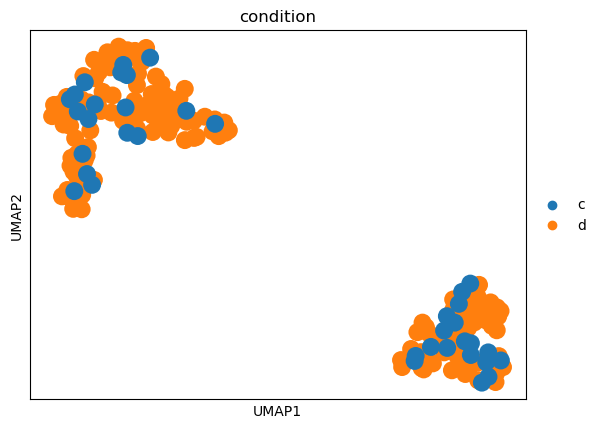

In [381]:
sc.pl.umap(ffdds, color= 'condition')

PCA results indicate that the TMAs and TWAs in 2 clusters sharing similar aspects, with minimal batch effects

# lncRNA

In [38]:
for i in range(1, 143):
    tmdf[f'tm{i}'] = tmdf[f'tm{i}'][tmdf[f'tm{i}']["gene_type"] == "lncRNA"]
for i in range(1, 39):
    twdf[f'tw{i}'] = twdf[f'tw{i}'][twdf[f'tw{i}']["gene_type"] == "lncRNA"]
    
twun = pd.DataFrame()
for i in range(1,39):
    new_column = pd.DataFrame(zip(twdf[f'tw{i}']['unstranded']),columns = [f'tw{i}'])
    twun = pd.concat([twun, new_column], axis=1)
    
tmun = pd.DataFrame()
for i in range(1,143):
    new_column = pd.DataFrame(zip(tmdf[f'tm{i}']['unstranded']),columns = [f'tm{i}'])
    tmun = pd.concat([tmun, new_column], axis=1)
    
twcounts = pd.DataFrame(zip(tmdf['tm1']['gene_id']), columns = ['geneid']) # preparing the gene id column
counts = pd.concat([twcounts,tmun,twun], axis= 1) # preparing the counts table for DGE
counts = counts.set_index('geneid')
counts = counts[counts.sum(axis=1)>0]
counts = counts.T
m_list = ['d']* 143
w_list = ['c']* 38
condition_list = m_list + w_list
metadata = pd.DataFrame(zip(counts.index, condition_list), columns = ['sample','condition'])
metadata = metadata.set_index('sample')

# Differential Expression

In [39]:
dds = DeseqDataSet(counts = counts,
                  metadata = metadata,
                  design_factors = 'condition')

In [40]:
dds = DeseqDataSet(counts = counts,
                  metadata = metadata,
                  design_factors = 'condition')
dds.deseq2()
stat_res = DeseqStats (dds, n_cpus = 10, contrast=('condition','d','c'))
stat_res.summary()
res = stat_res.results_df
linco= pd.merge(res, twdf['tw1'][['gene_id','gene_name']], left_on='geneid',right_on='gene_id')
degs = linco[(abs(linco.log2FoldChange) > 0.5)&(linco.padj<0.05)]

Fitting size factors...
... done in 0.12 seconds.

Fitting dispersions...
... done in 8.03 seconds.

Fitting dispersion trend curve...
... done in 7.85 seconds.

Fitting MAP dispersions...
... done in 8.21 seconds.

Fitting LFCs...
... done in 54.26 seconds.

Refitting 830 outliers.

Fitting dispersions...
... done in 0.89 seconds.

Fitting MAP dispersions...
... done in 0.89 seconds.

Fitting LFCs...
... done in 0.90 seconds.

Running Wald tests...
... done in 9.36 seconds.



Log2 fold change & Wald test p-value: condition d vs c


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
geneid,,,,,,
ENSG00000082929.8,15.338126,0.234952,0.250731,0.937068,0.348724,0.816936
ENSG00000083622.8,80.485163,0.509860,0.408015,1.249610,0.211442,0.808916
ENSG00000093100.13,13.509626,0.457503,0.200061,2.286812,0.022207,0.539566
ENSG00000099869.8,19.775059,0.053344,0.304691,0.175074,0.861021,0.955842
ENSG00000103472.10,19.512350,-0.058337,0.150810,-0.386826,0.698885,0.895548
...,...,...,...,...,...,...
ENSG00000288659.1,0.186153,-0.052895,1.425556,-0.037105,0.970401,NaN
ENSG00000288662.1,8.297870,0.312188,0.385211,0.810433,0.417691,0.828300
ENSG00000288663.1,22.203233,-0.066275,0.126171,-0.525280,0.599389,0.863498


# GSEA lncRNA

In [41]:
ranking = linco[['gene_name','stat']].dropna().sort_values('stat',ascending= False)

In [42]:
ranking

,gene_name,stat
2430,AC011287.1,5.663576
1043,AC010789.1,5.317822
6260,PURPL,5.019843
13277,FP236383.3,4.937115
2850,LINC01436,4.824735
...,...,...
15245,AL732437.2,-4.881078
11202,LINC01711,-4.945275
4710,UNC5B-AS1,-5.050205
6993,AC091182.2,-5.062578


In [43]:
pre_res1 = gp.prerank (rnk= ranking, gene_sets = r" \Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c2.cp.kegg.v2023.1.Hs.symbols.gmt", min_size = 3) #Replace with path, no results for this set
out1 = []

for term in list(pre_res1.results):
    out1.append([term,
               pre_res1.results[term]['fdr'],
               pre_res1.results[term]['es'],
               pre_res1.results[term]['nes'],
               pre_res1.results[term]['pval'],
                pre_res1.results[term]['matched_genes']])

out_df1 = pd.DataFrame(out1, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df1

2024-07-08 21:18:09,744 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 21:18:09,782 [WARNING] Duplicated values found in preranked stats: 2.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-08 21:18:09,821 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2024-07-08 21:18:09,829 [ERROR] The first entry of your gene_sets (gmt) look like this : { KEGG_N_GLYCAN_BIOSYNTHESIS: [ALG13, DOLPP1, RPN1, ALG14, MAN1B1, ALG3, B4GALT1, MGAT5, RPN2, STT3A, MGAT3, DAD1, MGAT2, ALG12, TUSC3, MAN1C1, DPM2, DPM1, GANAB, ALG1, MGAT4A, ALG10B, STT3B, MAN1A2, ALG10, ALG11, ALG8, ALG2, DPAGT1, RFT1, DPM3, DDOST, MGAT4B, ALG6, MAN2A2, MAN1A1, MAN2A1, ST6GAL1, B4GALT3, ALG5, B4GALT2, MGAT5B, ALG9, 

LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.


In [53]:
pre_res2 = gp.prerank (rnk= ranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c3.all.v2023.1.Hs.symbols.gmt", min_size =3) #Replace with path 
out2 = []

for term in list(pre_res2.results):
    out2.append([term,
               pre_res2.results[term]['fdr'],
               pre_res2.results[term]['es'],
               pre_res2.results[term]['nes'],
               pre_res2.results[term]['pval'],
                pre_res2.results[term]['matched_genes']])

out_df2 = pd.DataFrame(out2, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df2

2024-07-08 21:46:03,309 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 21:46:03,322 [WARNING] Duplicated values found in preranked stats: 2.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,ZNF513_TARGET_GENES,0.011695,-0.555179,-2.189123,0.000000,HOXB-AS3;MIR124-1HG;LINC00461;RNF217-AS1;SLIT3...
1,DNMT1_TARGET_GENES,0.037520,-0.742609,-1.995606,0.006349,CENATAC-DT;AFDN-DT;LINC02380;OTUD6B-AS1;PRANCR...
2,SMTTTTGT_UNKNOWN,0.042231,-0.818718,-2.011062,0.000000,ZNF436-AS1;KIRREL3-AS3;PRR34;COLCA1;ILF3-DT;MI...
3,FXR1_TARGET_GENES,0.044830,-0.486271,-1.961863,0.000000,ALOX12-AS1;MORC2-AS1;BMS1P4;HCG25;PRMT5-AS1;SE...
4,CHAF1A_TARGET_GENES,0.056524,-0.835714,-2.024104,0.000000,CDYL-AS1;ZMIZ1-AS1;IRAIN;LINC01664;SCAMP1-AS1;...
...,...,...,...,...,...,...
662,ZNF362_TARGET_GENES,1.000000,0.322279,1.035018,0.424516,HOXA11-AS;BMS1P4;FANK1-AS1;LINC01842;WEE2-AS1;...
663,NKX2_5_TARGET_GENES,1.000000,0.269007,0.999099,0.473746,LINC00339;LINC02474;PCAT7;SOX2-OT;TMEM202-AS1;...
664,AEBP2_TARGET_GENES,1.000000,0.269040,0.933385,0.598773,RNFT1-DT;INKA2-AS1;PCAT7;KLF3-AS1;TMEM202-AS1;...
665,SKIL_TARGET_GENES,1.000000,0.256896,0.987417,0.497136,PURPL;RNFT1-DT;LINC00511;PCAT7;GRHL3-AS1;CXXC4...


In [44]:
pre_res3 = gp.prerank (rnk= ranking, gene_sets = r" \Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c3.mir.v2023.1.Hs.symbols.gmt", min_size = 3) #Replace with path 
out3 = []

for term in list(pre_res3.results):
    out3.append([term,
               pre_res3.results[term]['fdr'],
               pre_res3.results[term]['es'],
               pre_res3.results[term]['nes'],
               pre_res3.results[term]['pval'],
                pre_res3.results[term]['matched_genes']])

out_df3 = pd.DataFrame(out3, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df3

2024-07-08 21:27:31,772 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 21:27:31,803 [WARNING] Duplicated values found in preranked stats: 2.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,MIR765,0.386842,-0.806415,-1.378840,0.135802,CCDC28A-AS1;LMO7DN;LINC02873
1,MIR153_5P,0.477016,0.552258,1.023835,0.470497,DOCK8-AS1;RPP38-DT;CCDC28A-AS1;C15orf32;PELATON
2,MIR576_5P,0.935526,-0.347643,-0.589831,0.930851,LINC01517;RGS5;CCDC39
3,MIR664A_3P,0.963158,-0.487394,-0.834787,0.647520,RGS5;LMO7DN;C15orf32


In [45]:
pre_res4 = gp.prerank (rnk= ranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c3.tft.v2023.1.Hs.symbols.gmt", min_size = 3) #Replace with path 
out4 = []

for term in list(pre_res4.results):
    out4.append([term,
               pre_res4.results[term]['fdr'],
               pre_res4.results[term]['es'],
               pre_res4.results[term]['nes'],
               pre_res4.results[term]['pval'],
                pre_res4.results[term]['matched_genes']])

out_df4 = pd.DataFrame(out4, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df4

2024-07-08 21:27:40,518 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 21:27:40,545 [WARNING] Duplicated values found in preranked stats: 2.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,ZNF513_TARGET_GENES,0.011694,-0.555179,-2.189123,0.000000,HOXB-AS3;MIR124-1HG;LINC00461;RNF217-AS1;SLIT3...
1,DNMT1_TARGET_GENES,0.037517,-0.742609,-1.995606,0.006349,CENATAC-DT;AFDN-DT;LINC02380;OTUD6B-AS1;PRANCR...
2,SMTTTTGT_UNKNOWN,0.042227,-0.818718,-2.011062,0.000000,ZNF436-AS1;KIRREL3-AS3;PRR34;COLCA1;ILF3-DT;MI...
3,FXR1_TARGET_GENES,0.044825,-0.486271,-1.961863,0.000000,ALOX12-AS1;MORC2-AS1;BMS1P4;HCG25;PRMT5-AS1;SE...
4,CHAF1A_TARGET_GENES,0.056519,-0.835714,-2.024104,0.000000,CDYL-AS1;ZMIZ1-AS1;IRAIN;LINC01664;SCAMP1-AS1;...
...,...,...,...,...,...,...
658,TGCGCANK_UNKNOWN,1.000000,0.518094,0.965322,0.539557,RPP38-DT;DLEU2;C14orf178;LINC01106;DLEU1
659,MAML1_TARGET_GENES,1.000000,0.351783,1.071336,0.376159,LINC00511;EPN2-AS1;LINC01624;LINC02579;MIR155H...
660,MZF1_TARGET_GENES,1.000000,0.292189,1.086975,0.317536,HOXA11-AS;DLX6-AS1;IQCH-AS1;ADD3-AS1;HOXB-AS3;...
661,ZNF708_TARGET_GENES,1.000000,0.656243,1.158471,0.285714,LINC00662;JPX;HCCAT5;LINC01596


In [46]:
pre_res6 = gp.prerank (rnk= ranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c5.go.bp.v2023.1.Hs.symbols.gmt", min_size = 3) #Replace with path 
out6 = []

for term in list(pre_res6.results):
    out6.append([term,
               pre_res6.results[term]['fdr'],
               pre_res6.results[term]['es'],
               pre_res6.results[term]['nes'],
               pre_res6.results[term]['pval'],
                pre_res6.results[term]['matched_genes']])

out_df6 = pd.DataFrame(out6, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df6

2024-07-08 21:33:29,888 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 21:33:29,905 [WARNING] Duplicated values found in preranked stats: 2.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,GOBP_NEGATIVE_REGULATION_OF_GENE_EXPRESSION,0.024008,0.588768,1.758262,0.001370,HOXA11-AS;HOXB-AS3;HOXA10-AS;MIR137HG;TSIX;CDK...
1,GOBP_POSITIVE_REGULATION_OF_GENE_EXPRESSION,0.072729,0.725684,1.625097,0.016845,HOXB-AS3;CDKN2B-AS1;CRYZL2P-SEC16B;FTX;H19;NEA...
2,GOBP_EPIGENETIC_REGULATION_OF_GENE_EXPRESSION,0.193473,0.827221,1.445428,0.035200,TSIX;CDKN2B-AS1;XIST;KCNQ1OT1
3,GOBP_CHROMATIN_REMODELING,0.193473,0.827221,1.445428,0.035200,TSIX;CDKN2B-AS1;XIST;KCNQ1OT1
4,GOBP_HETEROCHROMATIN_ORGANIZATION,0.193473,0.827221,1.445428,0.035200,TSIX;CDKN2B-AS1;XIST;KCNQ1OT1
...,...,...,...,...,...,...
58,GOBP_RNA_CATABOLIC_PROCESS,0.896127,0.431891,0.704617,0.884679,KCNQ1OT1;MIAT;GAS5
59,GOBP_REGULATION_OF_MIRNA_CATABOLIC_PROCESS,0.896127,0.431891,0.704617,0.884679,KCNQ1OT1;MIAT;GAS5
60,GOBP_RESPONSE_TO_ENDOGENOUS_STIMULUS,0.965876,0.351647,0.579555,0.953411,KCNQ1OT1;FBXW7-AS1;GAS5
61,GOBP_POSITIVE_REGULATION_OF_MACROMOLECULE_BIOS...,1.000000,-0.706346,-1.224514,0.276215,NFE4;BACE1-AS;MIR9-1HG


In [47]:
pre_res7 = gp.prerank (rnk= ranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c5.go.cc.v2023.1.Hs.symbols.gmt", min_size = 3) #Replace with path 
out7= []

for term in list(pre_res7.results):
    out7.append([term,
               pre_res7.results[term]['fdr'],
               pre_res7.results[term]['es'],
               pre_res7.results[term]['nes'],
               pre_res7.results[term]['pval'],
                pre_res7.results[term]['matched_genes']])

out_df7 = pd.DataFrame(out7, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df7

2024-07-08 21:34:16,452 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 21:34:16,484 [WARNING] Duplicated values found in preranked stats: 2.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,GOCC_NUCLEAR_PROTEIN_CONTAINING_COMPLEX,0.072896,0.815528,1.465536,0.033691,TERC;TSIX;WEE2-AS1;OVAAL
1,GOCC_RIBONUCLEOPROTEIN_COMPLEX,0.086150,0.540400,1.490408,0.039829,HOXA10-AS;MIR137HG;TERC;LINC00461;WEE2-AS1;SNA...
2,GOCC_SEX_CHROMOSOME,0.097084,0.847426,1.398252,0.052215,TSIX;FIRRE;XIST
3,GOCC_CHROMOSOME,0.165673,0.847479,1.494808,0.021978,TERC;TSIX;FIRRE;XIST
4,GOCC_NUCLEOLUS,0.217550,-0.452168,-1.231691,0.178042,ELOVL2-AS1;PCAT18;KCNQ1OT1;SCARNA9;LINC01151;S...
5,GOCC_RNAI_EFFECTOR_COMPLEX,0.226640,0.494400,1.239904,0.200000,HOXA10-AS;MIR137HG;LINC00461;MEG3;MIR155HG;NEA...
6,GOCC_NUCLEAR_BODY,0.477800,0.626127,1.009730,0.481164,TERC;NEAT1;SNHG10


In [48]:
pre_res8 = gp.prerank (rnk= ranking, gene_sets = "GO_Molecular_Function_2023", min_size = 3) 
out8 = []

for term in list(pre_res8.results):
    out8.append([term,
               pre_res8.results[term]['fdr'],
               pre_res8.results[term]['es'],
               pre_res8.results[term]['nes'],
               pre_res8.results[term]['pval'],
                pre_res8.results[term]['matched_genes']])

out_df8 = pd.DataFrame(out8, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df8

2024-07-08 21:34:26,047 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 21:34:26,092 [WARNING] Duplicated values found in preranked stats: 2.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-08 21:34:26,187 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2024-07-08 21:34:26,189 [ERROR] The first entry of your gene_sets (gmt) look like this : { 1-Acylglycerol-3-Phosphate O-acyltransferase Activity (GO:0003841): [LPGAT1, MBOAT7, TAFAZZIN, LPCAT2, MBOAT2, LPCAT1, AGPAT1, AGPAT2, CRLS1, LCLAT1, AGPAT3, AGPAT4, AGPAT5, MBOAT1, LPCAT3, GPAT2, GPAT4, GPAT3, PNPLA3]}
2024-07-08 21:34:26,198 [ERROR] The first 5 genes look like this : [ AC011287.1, AC010789.1, PURPL, FP236383.3, LINC

LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.


In [49]:
pre_res9 = gp.prerank (rnk= ranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c5.hpo.v2023.1.Hs.symbols.gmt", min_size = 3) #Replace with path 
out9= []

for term in list(pre_res9.results):
    out9.append([term,
               pre_res9.results[term]['fdr'],
               pre_res9.results[term]['es'],
               pre_res9.results[term]['nes'],
               pre_res9.results[term]['pval'],
                pre_res9.results[term]['matched_genes']])

out_df9 = pd.DataFrame(out9, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df9

2024-07-08 21:43:16,976 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 21:43:16,988 [WARNING] Duplicated values found in preranked stats: 2.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,HP_ABNORMAL_INFLAMMATORY_RESPONSE,0.209038,0.758055,1.417586,0.068182,TERC;MEG3;RMRP;IL12A-AS1;CCDC39
1,HP_ABNORMAL_RETINAL_MORPHOLOGY,0.209038,0.758055,1.417586,0.068182,TERC;MEG3;RMRP;IL12A-AS1;CCDC39
2,HP_ABNORMALITY_OF_THE_SPLEEN,0.209038,0.758055,1.417586,0.068182,TERC;MEG3;RMRP;IL12A-AS1;CCDC39
3,HP_ABNORMALITY_OF_THE_DENTITION,0.209109,0.766666,1.439980,0.044628,TERC;H19;KCNQ1OT1;RMRP;PWRN1
4,HP_INTRAUTERINE_GROWTH_RETARDATION,0.214361,0.725279,1.441002,0.057508,TERC;MEG3;H19;HYMAI;RMRP;PWRN1
...,...,...,...,...,...,...
171,HP_ABNORMALITY_OF_REPRODUCTIVE_SYSTEM_PHYSIOLOGY,0.698329,-0.767082,-1.325367,0.165775,PWRN1;ATXN8OS;CCDC39
172,HP_ABNORMAL_LONG_BONE_MORPHOLOGY,0.732018,0.846512,1.588312,0.006431,TERC;GNAS-AS1;MEG3;RMRP;PWRN1
173,HP_ABNORMAL_CEREBRAL_VENTRICLE_MORPHOLOGY,0.814597,0.469099,0.770321,0.819699,KCNQ1OT1;PWRN1;CCDC39
174,HP_VENTRICULOMEGALY,0.814597,0.469099,0.770321,0.819699,KCNQ1OT1;PWRN1;CCDC39


In [50]:
pre_res10 = gp.prerank (rnk= ranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\c6.all.v2023.1.Hs.symbols.gmt", min_size = 3) #Replace with path 
out10 = []

for term in list(pre_res10.results):
    out10.append([term,
               pre_res10.results[term]['fdr'],
               pre_res10.results[term]['es'],
               pre_res10.results[term]['nes'],
               pre_res10.results[term]['pval'],
                pre_res10.results[term]['matched_genes']])

out_df10 = pd.DataFrame(out10, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df10

2024-07-08 21:44:33,367 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 21:44:33,384 [WARNING] Duplicated values found in preranked stats: 2.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,KRAS.LUNG_UP.V1_UP,0.782218,0.769407,1.241770,0.182724,LINC00472;MIR124-1HG;N4BP2L2-IT2
1,STK33_NOMO_DN,0.786870,0.580497,1.205838,0.239329,DLX6-AS1;DOCK8-AS1;LINC00926;MROCKI;UCA1;HCG11...
2,NFE2L2.V2,0.830866,0.404975,0.813142,0.708861,SOX2-OT;AQP4-AS1;NFE4;MCF2L-AS1;LY86-AS1;LINC0...
3,MTOR_UP.N4.V1_DN,0.855645,0.466517,0.826360,0.743178,LINC00342;NEAT1;POLR2J4;HHLA3
4,STK33_NOMO_UP,0.873219,0.627892,1.122753,0.332273,LINC02003;DPP10-AS1;NEAT1;MIR22HG
5,JAK2_DN.V1_DN,0.894801,0.506424,1.147442,0.297965,LINC00937;PVT1;NEAT1;C8orf44;HYMAI;POLR2J4;HCG...
6,E2F3_UP.V1_DN,0.899417,0.340984,0.829376,0.704918,PVT1;LINC00662;GAS8-AS1;SND1-IT1;KCNQ1OT1;WT1-...
7,SRC_UP.V1_DN,0.924324,0.398196,0.697369,0.860427,MIR17HG;WT1-AS;DGCR11;LINC00842
8,PDGF_UP.V1_DN,0.928169,0.424580,0.843381,0.711569,MIR124-1HG;LINC01558;SMG7-AS1;INE1;ATXN8OS;GAB...
9,STK33_SKM_DN,0.947683,0.485238,1.042812,0.412371,DPP10-AS1;LINC00926;LINC01913;BFSP2-AS1;LINC02...


In [51]:
pre_res12 = gp.prerank (rnk= ranking, gene_sets = r"\Gene Sets\msigdb_v2023.1.Hs_GMTs\MSigDB\h.all.v2023.1.Hs.symbols.gmt", min_size = 3) #Replace with path 
out12= []

for term in list(pre_res12.results):
    out12.append([term,
               pre_res12.results[term]['fdr'],
               pre_res12.results[term]['es'],
               pre_res12.results[term]['nes'],
               pre_res12.results[term]['pval'],
                pre_res12.results[term]['matched_genes']])

out_df12 = pd.DataFrame(out12, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df12

2024-07-08 21:44:47,541 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 21:44:47,554 [WARNING] Duplicated values found in preranked stats: 2.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-08 21:44:47,564 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2024-07-08 21:44:47,567 [ERROR] The first entry of your gene_sets (gmt) look like this : { HALLMARK_TNFA_SIGNALING_VIA_NFKB: [JUNB, CXCL2, ATF3, NFKBIA, TNFAIP3, PTGS2, CXCL1, IER3, CD83, CCL20, CXCL3, MAFF, NFKB2, TNFAIP2, HBEGF, KLF6, BIRC3, PLAUR, ZFP36, ICAM1, JUN, EGR3, IL1B, BCL2A1, PPP1R15A, ZC3H12A, SOD2, NR4A2, IL1A, RELB, TRAF1, BTG2, DUSP1, MAP3K8, ETS2, F3, SDC4, EGR1, IL6, TNF, KDM6B, NFKB1, LIF, PTX3, FOSL1, N

LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.


In [52]:
pre_res13 = gp.prerank (rnk= ranking, gene_sets = 'miRTarBase_2017', min_size = 3) 
out13 = []

for term in list(pre_res13.results):
    out13.append([term,
               pre_res13.results[term]['fdr'],
               pre_res13.results[term]['es'],
               pre_res13.results[term]['nes'],
               pre_res13.results[term]['pval'],
                pre_res13.results[term]['matched_genes']])

out_df13 = pd.DataFrame(out13, columns = ['Term','fdr', 'es', 'nes','pval','matched_genes']).sort_values('fdr').reset_index(drop = True)
out_df13

2024-07-08 21:44:56,926 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2024-07-08 21:44:56,937 [WARNING] Duplicated values found in preranked stats: 2.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes,pval,matched_genes
0,hsa-miR-6799-5p,0.687733,0.605800,1.002373,0.490260,SLFN12L;LINC00598;DNAH10OS
1,hsa-miR-3689a-3p,0.687733,0.605800,1.002373,0.490260,SLFN12L;LINC00598;DNAH10OS
2,hsa-miR-3689b-3p,0.687733,0.605800,1.002373,0.490260,SLFN12L;LINC00598;DNAH10OS
3,hsa-miR-30b-3p,0.687733,0.605800,1.002373,0.490260,SLFN12L;LINC00598;DNAH10OS
4,hsa-miR-1273h-5p,0.687733,0.605800,1.002373,0.490260,SLFN12L;LINC00598;DNAH10OS
...,...,...,...,...,...,...
61,hsa-miR-6499-3p,1.000000,-0.459450,-0.870245,0.601583,SLFN12L;ELFN2;COLCA1;ARIH2OS
62,hsa-miR-124-3p,1.000000,0.719925,1.269790,0.158756,HOTAIR;NEAT1;DLEU1;CCDC39
63,hsa-miR-873-3p,1.000000,0.740429,1.310582,0.122222,TSPEAR-AS2;SLFN12L;LINC01556;HTR5A-AS1
64,hsa-miR-4279,1.000000,-0.355117,-0.615485,0.929293,TMEM78;LINC00598;LINC01560


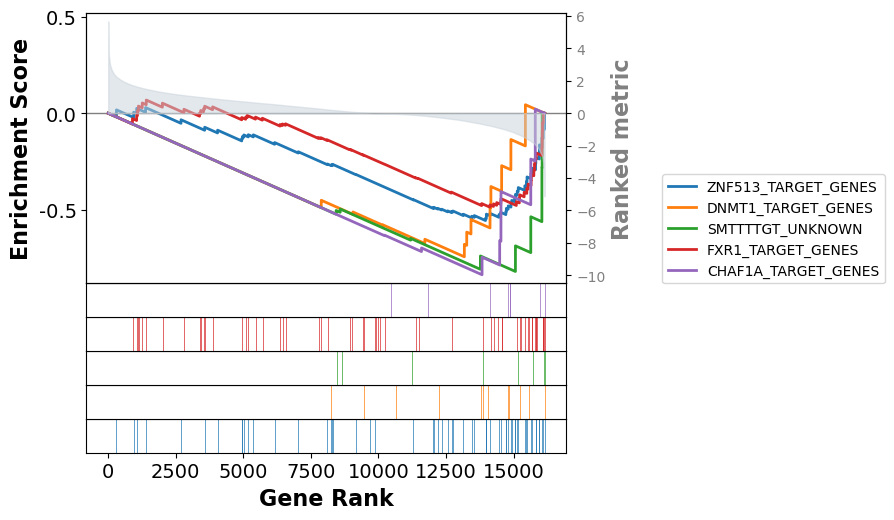

In [295]:
axs = pre_res13.plot(terms=out_df13.iloc[0:5].Term,
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis 
                   figsize=(4,5),
                  legend_kws={'loc':(1.2,0)})
    #c3.all.v2023.1.Hs.symbols.gmt

# SOME FIGURES

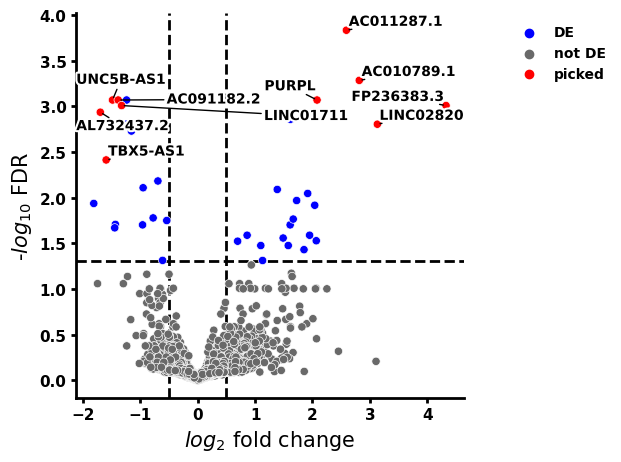

In [683]:
volcano(linco, symbol = 'gene_name', pval_thresh =0.05, log2fc_thresh = 0.5, colors= ['blue','dimgrey','red'])

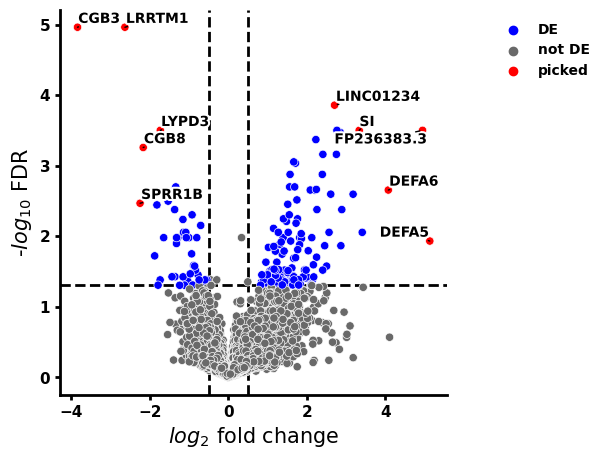

In [676]:
volcano(ffres, symbol = 'gene_name', pval_thresh =0.05, log2fc_thresh = 0.5, colors= ['blue','dimgrey','red'])

In [541]:
dds.layers['log1p']= np.log1p(dds.layers['normed_counts'])

In [565]:
ndegs=degs.set_index('gene_id')

In [566]:
ddsigs= dds[:,ndegs.index]
cluster = pd.DataFrame(ddsigs.layers['log1p'].T,
index=ddsigs.var_names,
columns=ddsigs.obs_names)

In [689]:
ddsigs

AnnData object with n_obs × n_vars = 180 × 38
    obs: 'condition'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var', 'pca', 'condition_colors', 'neighbors', 'umap'
    obsm: 'design_matrix', 'size_factors', 'replaceable', 'X_pca', 'X_umap'
    varm: 'non_zero', '_rough_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'PCs'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks', 'log1p'
    obsp: 'distances', 'connectivities'

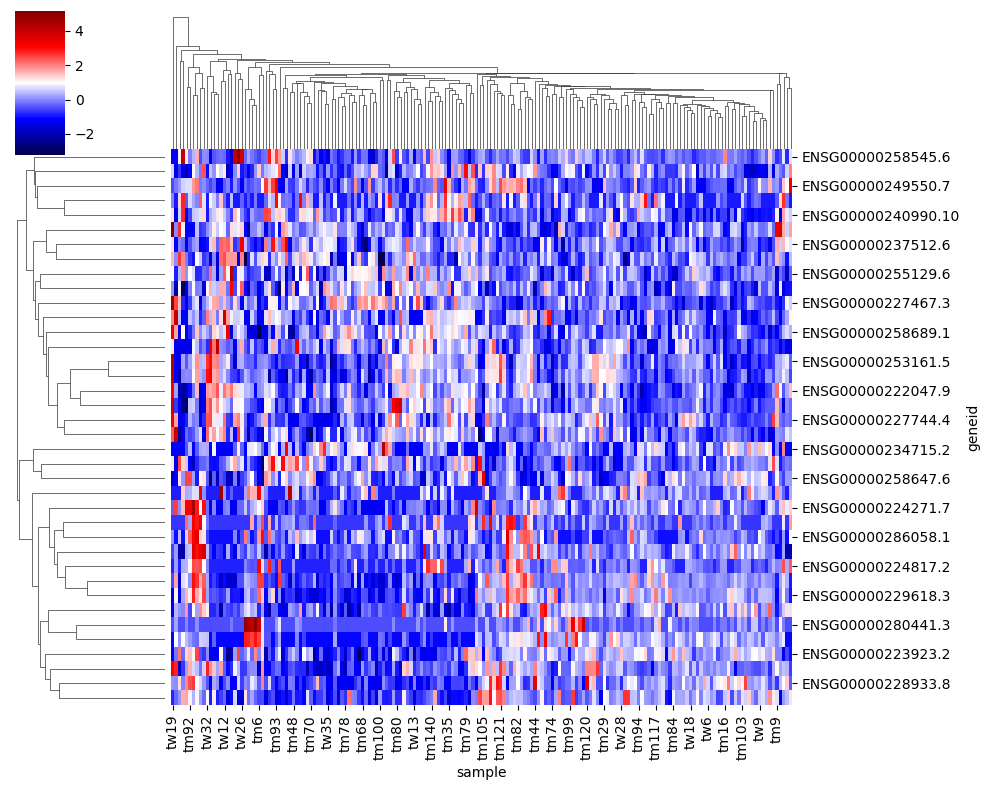

In [609]:
sns.clustermap(cluster, z_score=0, cmap="seismic",figsize=(10,8))

In [568]:
heat= cluster.T
correlation = heat.corr()
# Create a new dataframe with the gene names as the index and columns
heatmap_df = pd.DataFrame(correlation, index=cluster.index, columns=cluster.index)

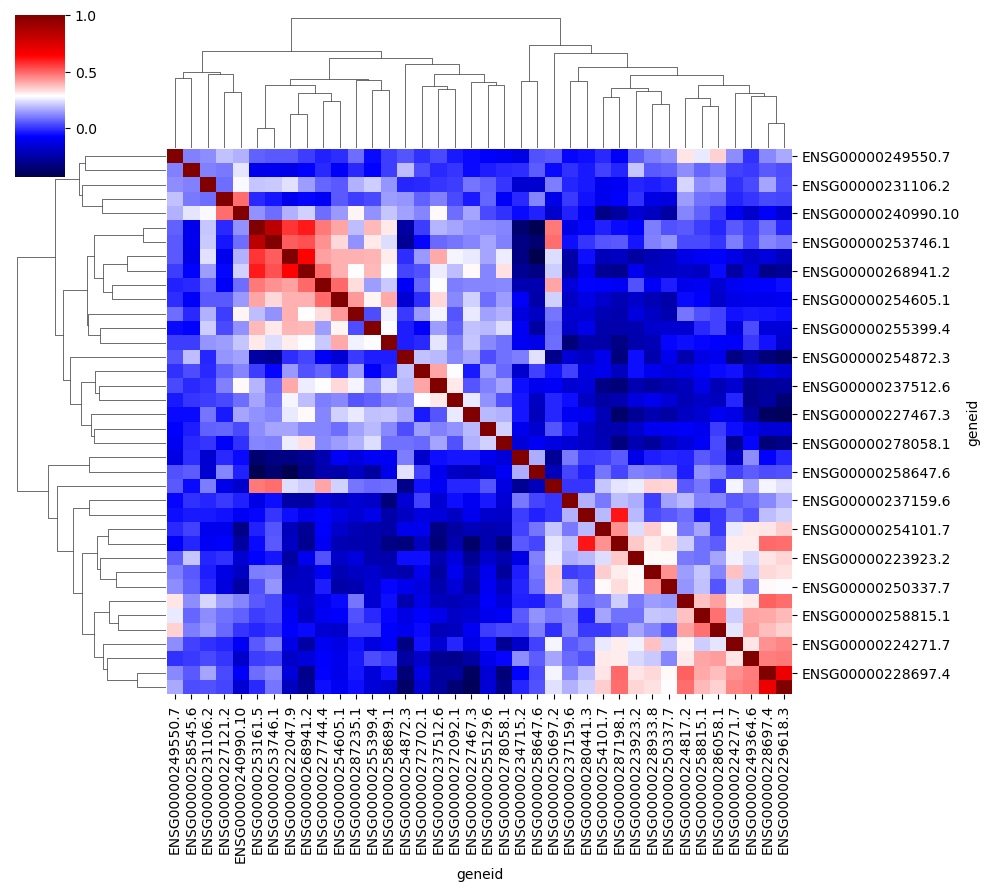

In [606]:
sns.clustermap(correlation,figsize=(10,9),cmap= 'seismic')


# PCA lncRNA 

# TPM for scanpy

In [367]:
tpwun = pd.DataFrame()
for i in range(1,39):
    new_column = pd.DataFrame(zip(twdf[f'tw{i}']['tpm_unstranded']),columns = [f'tw{i}'])
    tpwun = pd.concat([tpwun, new_column], axis=1)

In [368]:
tpmun = pd.DataFrame()
for i in range(1,143):
    new_column = pd.DataFrame(zip(tmdf[f'tm{i}']['tpm_unstranded']),columns = [f'tm{i}'])
    tpmun = pd.concat([tpmun, new_column], axis=1)

In [369]:
tcounts = pd.DataFrame(zip(tmdf['tm1']['gene_id']), columns = ['geneid']) # preparing the gene id column

In [370]:
tpcounts = pd.concat([tcounts,tpmun,tpwun], axis= 1) # preparing the counts table for DGE no controlsssss

In [371]:
tpcounts= tpcounts.set_index('geneid')

In [385]:
tpcounts = tpcounts.T

In [373]:
intpc=tpcounts.astype(int)

In [393]:
X.T.index

Index(['C10orf55', 'TNS1-AS1', 'AL117329.1', 'AC010789.1', 'LINC02672',
       'LINC01537', 'LINC01940', 'AL023755.1', 'AC107419.1', 'AC011287.1',
       'LINC01436', 'AC005064.1', 'CNTFR-AS1', 'UNC5B-AS1', 'HOXA11-AS',
       'AC112206.2', 'LINC01234', 'PURPL', 'AC010343.3', 'LINC01605',
       'AC091182.2', 'LINC02055', 'AP003555.1', 'LINC02688', 'AP000880.1',
       'TBX5-AS1', 'RHOXF1-AS1', 'LINC00930', 'LINC01269', 'LINC02820',
       'LINC01711', 'AC087623.2', 'AC010913.1', 'AC009159.3', 'FP236383.3',
       'AC018865.2', 'AC092979.2', 'AL732437.2'],
      dtype='object')

In [394]:
tpm4ml = pd.merge(tpcounts, tmdf['tm1'][['gene_id','gene_name']], left_on= tpcounts.index, right_on=tmdf['tm1']['gene_id'], how= 'right')

In [417]:
bsdf = X.T

In [418]:
tpmcountdf = pd.merge(tpm4ml,bsdf, left_on=tpm4ml['gene_name'], right_on= bsdf.index, how= 'right' )

In [402]:
tpm4ml= tpm4ml.drop(columns='key_0')

In [421]:
tpm4ml= tpm4ml.set_index('gene_name')

In [422]:
tpm4ml= tpm4ml[tpm4ml.index.isin(bsdf.index)]

In [424]:
tpm4ml= tpm4ml.drop(columns='gene_id')

In [563]:
tpm4ml= tpm4ml.drop(columns='condition')

In [426]:
tpm4ml=tpm4ml.T

In [564]:
fitpmdf= pd.merge(tpm4ml, metadata2[['sample','condition']], left_on=tpm4ml.index, right_on=metadata2['sample'], how='right')

In [567]:
fitpmdf = fitpmdf.drop(columns=['key_0','sample'])

In [569]:
fitpmdf.to_csv('tpmallml.csv',sep=',')

In [549]:
tpm4ml['condition']= metadata2['condition']

In [377]:
tpdds = DeseqDataSet(counts = intpc,
                  metadata = metadata,
                  design_factors = 'condition')

In [378]:
sc.tl.pca(tpdds)

C:\Users\Hasan\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


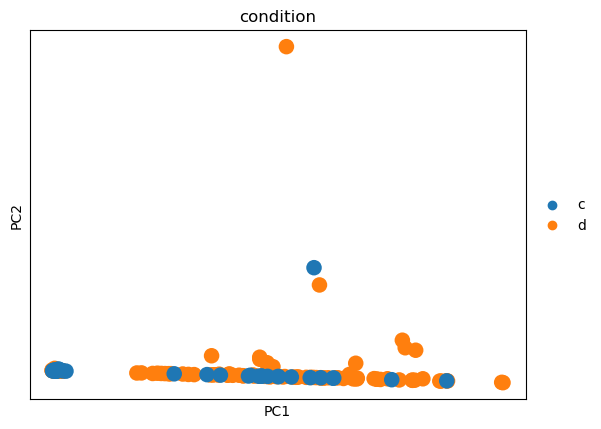

In [379]:
sc.pl.pca(tpdds, color = 'condition', size = 500)

In [387]:
sc.pp.neighbors(tpdds,n_pcs=20)

In [388]:
sc.tl.umap(tpdds)

C:\Users\Hasan\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


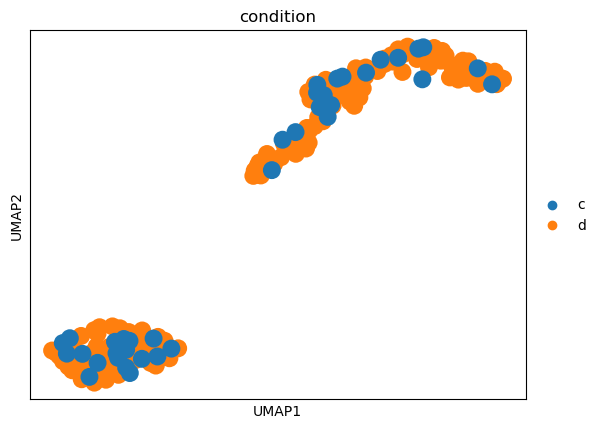

In [389]:
sc.pl.umap(tpdds, color= 'condition')

# SCALED ML

In [516]:
transformedx = np.log1p(X)

In [517]:
transformedx

,C10orf55,TNS1-AS1,AL117329.1,AC010789.1,LINC02672,LINC01537,LINC01940,AL023755.1,AC107419.1,AC011287.1,...,LINC01269,LINC02820,LINC01711,AC087623.2,AC010913.1,AC009159.3,FP236383.3,AC018865.2,AC092979.2,AL732437.2
0,4.219508,3.218876,2.079442,0.693147,2.397895,2.944439,3.871201,2.833213,1.098612,3.688879,...,2.397895,0.693147,4.110874,3.044522,1.791759,3.433987,0.693147,0.000000,1.791759,2.639057
1,3.135494,3.850148,2.079442,0.000000,0.000000,1.386294,1.791759,2.484907,2.302585,3.044522,...,1.791759,0.693147,3.988984,3.526361,1.945910,2.944439,0.693147,1.098612,2.995732,2.079442
2,3.218876,4.406719,2.302585,0.000000,0.000000,2.079442,2.833213,2.484907,3.496508,3.044522,...,3.737670,1.098612,4.700480,2.833213,2.079442,2.890372,0.000000,0.000000,2.708050,1.098612
3,3.496508,3.218876,3.526361,0.693147,1.609438,1.945910,1.945910,3.091042,2.890372,3.258097,...,2.708050,0.693147,4.189655,3.806662,2.484907,3.091042,0.000000,2.079442,2.484907,1.098612
4,3.178054,4.189655,0.693147,0.000000,0.000000,1.609438,4.094345,1.098612,1.609438,0.693147,...,2.944439,0.000000,3.988984,2.890372,0.693147,2.708050,0.000000,0.000000,0.000000,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,4.204693,1.791759,0.000000,0.000000,0.693147,3.044522,2.564949,0.693147,1.098612,1.386294,...,3.401197,0.000000,4.905275,2.772589,0.693147,2.639057,0.000000,0.000000,0.000000,0.693147
176,3.367296,1.791759,0.693147,0.000000,0.693147,2.079442,0.000000,1.098612,0.000000,1.386294,...,3.583519,0.000000,3.433987,3.044522,2.484907,3.465736,0.000000,0.000000,0.000000,0.000000
177,3.258097,2.944439,1.791759,1.386294,0.000000,2.079442,4.077537,2.772589,1.386294,2.890372,...,3.091042,0.693147,3.988984,3.135494,2.772589,3.218876,0.693147,1.609438,1.386294,1.945910
178,2.995732,2.484907,1.609438,0.693147,2.079442,0.693147,1.098612,2.079442,1.386294,2.197225,...,1.791759,0.000000,2.995732,4.262680,1.609438,2.708050,1.609438,0.000000,1.386294,0.000000


In [518]:
# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(transformedx)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=69)


# MACHINE LEARNING

# Data cleaning for ML
Here we first take raw counts data. Then, we merge the gene_id column from degs dataframe (differentially expressed genes) with the counts data to get a dataframe containing only the differentially expressed. Afterwards, we drop differential expression data, add the conditions from the metadata (which we used for differential expression above).

Finally, we prepare X_train, y_train, and tests for the ML models.
This is not needed to try as all preprocessed data was saved separately to immediately implement in the machine learning models.

In [468]:
mlcounts= counts.T
sigmlcounts = pd.merge(mlcounts, degs,left_on='geneid', right_on='gene_id', how='right')
fmlcounts =sigmlcounts.drop(columns=['baseMean','log2FoldChange','lfcSE','stat','pvalue','padj','gene_id'])
fmlcounts= fmlcounts.set_index('gene_name')
fcounts= fmlcounts.T
m_list = ['1']* 142
w_list = ['0'] * 38
condition_list = m_list + w_list
metadata2 = pd.DataFrame(zip(fcounts.index, condition_list), columns = ['sample','condition'])
ficounts= pd.merge(fcounts,metadata2['condition'], left_on=fcounts.index,right_on=metadata.index,how='right')
ficounts= ficounts.drop(columns='key_0')
X = ficounts.iloc[:,:-1]
y = ficounts['condition'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=69)
smote=SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)